In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import *
from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [37]:
n = 4  # Maximum length of a input
N = 2**n # Total number of inputs (Domain)
X = Y = Z = range(N) # Domain 

Consider now two functions $F : X \rightarrow Z$ and $G : Y \rightarrow Z$ that have the same codomain. By denition, a claw is a pair $x \in X$ , $y \int Y$ such that $F(x) = G(y)$.

In [48]:
F = { i : np.random.randint(0,N)  for i in X}
G = { i : np.random.randint(0,N) for i in Y}

In [49]:
F

{0: 1,
 1: 15,
 2: 9,
 3: 5,
 4: 0,
 5: 15,
 6: 1,
 7: 8,
 8: 15,
 9: 11,
 10: 11,
 11: 2,
 12: 7,
 13: 9,
 14: 0,
 15: 5}

In [50]:
G

{0: 9,
 1: 7,
 2: 15,
 3: 4,
 4: 10,
 5: 10,
 6: 11,
 7: 1,
 8: 3,
 9: 9,
 10: 3,
 11: 7,
 12: 13,
 13: 8,
 14: 0,
 15: 5}

Pick an arbitrary subset $K \subseteq X$ of cardinality $k$.

In [51]:
k = int(np.ceil(np.cbrt(N)))
K = np.random.choice(X, k, replace=False)
K

array([7, 3, 4])

Construct a table $L$ of size $k$ where each item in $L$ holds a distinct pair $(x, F(x))$ with $x \in K$. Sort $L$ according to the second entry in each item of $L$.

In [52]:
L = [ (i, F[i]) for i in K]
L.sort(key = lambda x: x[1])
L

[(4, 0), (3, 5), (7, 8)]

Compute $y_0$ = $Grover(H, 1)$ where $H : Y \rightarrow \{0,1\}$ denotes the function defined by $H(y) = 1$ if and only if a pair $(x, G(y))$ appears in $L$ for some arbitrary $x \in K$.

In [57]:
def search(y):
    """
    Check whether there exists x ∈ K so that (x, G(y)) ∈ L but x not = y.
    Since L is sorted by hashes we use binary search on L.  

    Args:
        y (int): Input y
    Returns:
        index (int): Returns the index of x if found, else -1
    
    """
    low = 0
    high = k-1
    
    while low <= high:
        mid = (low + high)//2
        
        # (x, G(y)) ∈ L but x not = y
        if L[mid][1] == G[y]:
            return L[mid][0]
        elif (L[mid][1] < G[y]):
            low = mid + 1
        else:
            high = mid - 1
    return -1

def H_mat():
    """ 
    Creates a unitary matrix for H: X -> {0, 1}  
    """
    
    size = 2**(n+1) # Since |X| = n, we need n+1 qubits
    U = np.zeros((size, size)) # Initialize the matrix
    
    for i in range(size):
        
        y = i&(2**n-1) # Get x from the first n bits        
        res = search(y) 
        
        if res == -1:
            U[i][i] = 1
        else:
            U[i^(2**n)][i] = 1
    
    print(U)
    qc = QuantumCircuit(n+1)
    qc.unitary(U,range(n+1))
    return qc.to_gate()


Inverse about the mean gate required for grover search

In [58]:
def inv_mean(n):
    """
    Creates a unitary matrix for inv_mean: X -> {0, 1}
    Args:
        n (int): Maximum number of bits in input
    Returns:
        inv_mean (QuantumCircuit): inv_mean unitary matrix
    """
    size = 2**(n)
    A = np.full((size,size), 1/size)
    I = np.identity(size)
    inv_mat = -I + 2*A
    qc = QuantumCircuit(n)
    qc.unitary(inv_mat,range(n))
    return qc.to_gate()

Compute $y_0$ = $Grover(H, 1)$

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


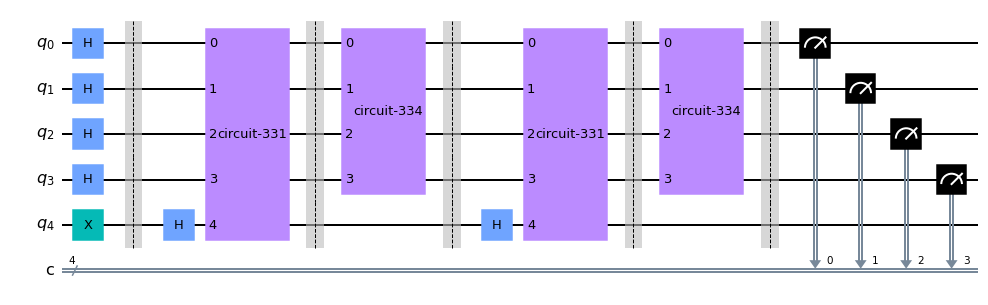

In [59]:
qc = QuantumCircuit(n+1,n)

qc.x(n)
for i in range(n):
    qc.h(i)
    
qc.barrier()

Uf = H_mat()
inv_gate = inv_mean(n)

num_iterations = int((np.pi/4) * np.ceil(np.sqrt((N)/k)))

for i in range(num_iterations):
    # Phase Inversion
    qc.h(n)
    
    qc.append(Uf, range(n+1))
    qc.barrier()

    # Inversion about mean
    qc.append(inv_gate, range(n))
    qc.barrier()


for i in range(n):
    qc.measure(i,i)

qc.draw('mpl')

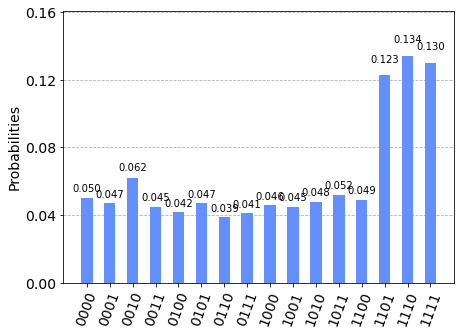

In [60]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')
res = execute(qc,backend=simulator, shots=shots).result()
counts = res.get_counts(qc)
plot_histogram(counts)

In [61]:
y0_s = [int(i,2) for i in res.get_counts(qc).keys()]
claws = []
for y0 in y0_s:
    x0 = search(y0)
    
    if x0 != -1:
        claws.append((x0, y0))

claws

[(4, 14), (7, 13), (3, 15)]